In [1]:
!pip install torchsummary --quiet
!pip install torchaudio --quiet
import torch
import torch.nn as nn
import numpy as np
from torchsummary import summary
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torchaudio
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)


### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']


config = {
    'Name': 'Gopal', # Write your name here
    'subset': 1.0, # Subset of dataset to use (1.0 == 100% of data)
    'context': 30,
    'archetype': 'diamond', # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'GELU',
    'learning_rate': 0.001,
    'dropout': 0.25,
    # 'dropout': 0.05,
    'optimizers': 'SGD',
    'scheduler': 'ReduceLROnPlateau',
    'epochs': 30,
    'batch_size': 2048,
    'weight_decay': 0.03,
    # 'weight_initialization': None, # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'weight_initialization' : "kaiming_normal",
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8
 }

Device:  cuda


In [2]:
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"gopalvenki","key":"3c76b5ea50eda8695b1fe0388683bb09"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=8e79e4e470d5fa0e17ebe0a4377e9cdcc7941fe3f89242bc9704f94fce28af9c
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [3]:
!kaggle competitions download -c 11785-spring-25-hw-1-p-2


!unzip -qo /kaggle/working/11785-spring-25-hw-1-p-2.zip -d /kaggle/working


100%|█████████████████████████████████████▉| 3.98G/3.98G [01:39<00:00, 39.2MB/s]
100%|██████████████████████████████████████| 3.98G/3.98G [01:39<00:00, 43.0MB/s]


In [4]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=20, partition= "train-clean-100"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes
        self.subset = config['subset']

        
        if config["augmentations"] in ["FreqMask", "Both"]:
            self.freq_masking = tat.FrequencyMasking(freq_mask_param = config["freq_mask_param"])
        else:
            self.freq_masking = None

        if config["augmentations"] in ["TimeMask", "Both"]:
            self.time_masking = tat.TimeMasking(time_mask_param = config["time_mask_param"])
        else:
            self.time_masking = None


        
        data_path = os.path.join(root, partition)
        self.mfcc_dir = os.path.join(data_path, 'mfcc')
        self.transcript_dir = os.path.join(data_path, 'transcript')

        
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        
        transcript_names = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(mfcc_names))

        # Select subset of data to use
        mfcc_names = mfcc_names[:subset_size]
        transcript_names = transcript_names[:subset_size]

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

            
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
            mfccs_normalized = (mfcc - np.mean(mfcc, axis = 0, keepdims = True))/(np.std(mfcc, axis = 0, keepdims = True) + 0.0000001)
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)
            transcript = np.load(os.path.join(self.transcript_dir, transcript_names[i]))
            transcript = transcript[1:-1]
            transcript_indices = [self.phonemes.index(phonome) for phonome in transcript]
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)

        self.mfccs = torch.cat(self.mfccs, dim = 0)


        self.transcripts = torch.cat(self.transcripts, dim = 0)

        self.length = len(self.mfccs)

        self.mfccs = nn.functional.pad(self.mfccs, (0,0, self.context, self.context), mode = "constant", value = 0)


    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        # frames = NotImplemented
        frames = self.mfccs[ind : (2 * self.context) + ind + 1 ]

        # After slicing, you get an array of shape 2*context+1 x 28.

        phonemes = self.transcripts[ind]

        return frames, phonemes



class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, context=0, partition= "test-clean"): # Feel free to add more arguments

        self.context    = context

        data_path = os.path.join(root, partition)
        self.mfcc_dir = os.path.join(data_path, 'mfcc')

        mfcc_names = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

 
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
     
            mfccs_normalized = (mfcc - np.mean(mfcc, axis = 0, keepdims = True))/np.std(mfcc, axis = 0, keepdims = True)
     
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)


            self.mfccs.append(mfccs_normalized)
            # self.transcripts.append(transcript_indices)

 
        self.mfccs = torch.cat(self.mfccs, dim = 0)

        self.length = len(self.mfccs)

        self.mfccs = nn.functional.pad(self.mfccs, (0,0, self.context, self.context), mode = "constant", value = 0)


    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):

        frames = self.mfccs[ind : (2 * self.context) + ind + 1 ]
        return frames



In [5]:
ROOT = "/kaggle/working/11785-s25-hw1p2" # Define the root directory of the dataset here

train_data = AudioDataset(ROOT, context = config['context'], partition= "train-clean-100")


val_data = AudioDataset(ROOT, context = config['context'], partition = "dev-clean")

test_data = AudioTestDataset(ROOT, context = config['context'], partition = "test-clean")

  0%|          | 0/28539 [00:00<?, ?it/s]

  0%|          | 0/2703 [00:00<?, ?it/s]

  0%|          | 0/2620 [00:00<?, ?it/s]

In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    # num_workers = 4,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  30
Input size     :  1708
Output symbols :  42
Train dataset samples = 36091157, batches = 17623
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 1934138, batches = 945


torch.Size([2048, 61, 28]) torch.Size([2048])


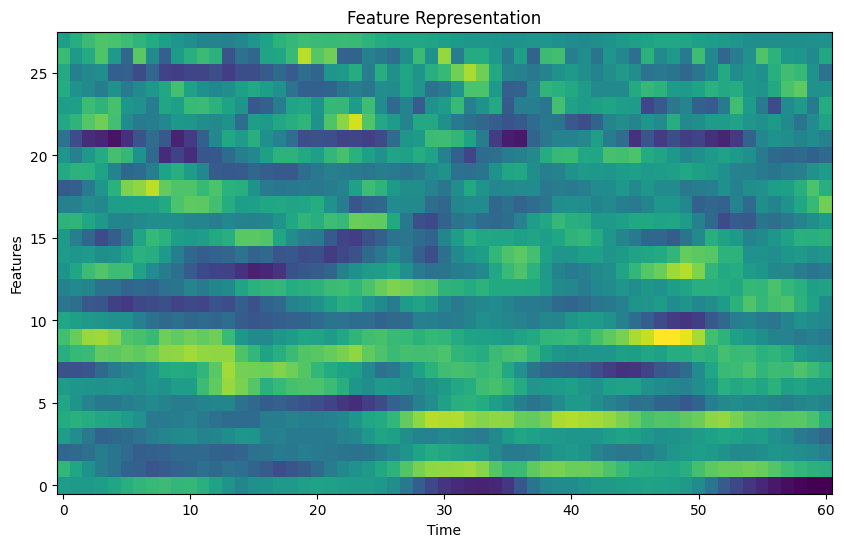

In [7]:
import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [8]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

In [9]:
import torch
import torch.nn as nn

class OptimizedNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Sequential(
                ResidualBlock(2048, 1024, expansion=0.75),
                SelfAttentionGate(1024),
                nn.Dropout(0.3)
            ),
            
            nn.Sequential(
                nn.Linear(1024, 2048),
                nn.LayerNorm(2048),
                nn.SiLU(),
                nn.Dropout(0.3)
            ),
            
            nn.Sequential(
                ResidualBlock(2048, 1024, expansion=0.5),
                SelfAttentionGate(1024),
                nn.Dropout(0.3)
            ),
            
            nn.Sequential(
                ResidualBlock(1024, 1024, expansion=0.5),
                nn.Dropout(0.2)
            ),
            
            nn.Sequential(
                nn.Linear(1024, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(0.2),

                nn.Linear(512, 256),
                nn.LayerNorm(256),
                nn.SiLU(),

                nn.Linear(256, output_size)
            )
        )
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.model(x.flatten(1))

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, expansion=0.5):
        super().__init__()
        hidden_dim = int(in_dim * expansion)
        self.block = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim),
            nn.LayerNorm(out_dim)
        )
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        return self.block(x) + self.shortcut(x)

class SelfAttentionGate(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, max(128, dim//8)),  
            nn.GELU(),
            nn.Linear(max(128, dim//8), dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return x * self.attn(x) + x  


In [10]:
INPUT_SIZE  = (2*config['context'] + 1) * 28 # Why is this the case?
model       = OptimizedNetwork(INPUT_SIZE, len(train_data.phonemes)).to(device)
summary(model, frames[0].to(device).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       3,500,032
         LayerNorm-2                 [-1, 2048]           4,096
              GELU-3                 [-1, 2048]               0
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 1536]       3,147,264
         LayerNorm-6                 [-1, 1536]           3,072
              GELU-7                 [-1, 1536]               0
            Linear-8                 [-1, 1024]       1,573,888
         LayerNorm-9                 [-1, 1024]           2,048
           Linear-10                 [-1, 1024]       2,098,176
    ResidualBlock-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
             GELU-13                  [-1, 128]               0
           Linear-14                 [-

In [11]:
!pip install triton>=2.2.0 lion-pytorch

from lion_pytorch import Lion

optimizer = Lion(
    model.parameters(),
    lr=3e-4,  
    weight_decay=1e-2,  
    use_triton=False  
)


In [12]:
from torch.optim.lr_scheduler import OneCycleLR

total_steps = config['epochs'] * len(train_loader)  

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3, 
    total_steps=total_steps,
    pct_start=0.3,  
    anneal_strategy='cos',  
    final_div_factor=100 
)


In [13]:
criterion = torch.nn.CrossEntropyLoss()

In [14]:
scaler = torch.cuda.amp.GradScaler(enabled=True)
torch.set_float32_matmul_precision('high')


<ipython-input-14-1401778c2c1d>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [15]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        # OPTIONAL: You can add gradient clipping here, if you face issues of exploding gradients

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [16]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

In [17]:
wandb.login(key="c59e320dfcb249ed2a66979ac2fff03bbddd8f3c") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gopalakt (gopalakt-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
# Create your wandb run
run = wandb.init(
    name    = "first-major-run11", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    id     = "1ealgvvf", ### Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "h1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [19]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/kaggle/working/wandb/run-20250206_021255-1ealgvvf/files/model_arch.txt']

In [35]:
# Restore checkpoint from wandb
restored_checkpoint = wandb.restore(f'checkpoint_epoch_{47}.pth')  # Replace with specific epoch

# Load checkpoint into model and optimizer
checkpoint = torch.load(restored_checkpoint.name)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if checkpoint.get('scheduler_state_dict'):
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Resume from the epoch saved in the checkpoint
start_epoch = checkpoint['epoch']
print(f"Resuming training from epoch {start_epoch}")


True
Resuming training from epoch 47


<ipython-input-35-4b82c42c3238>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(restored_checkpoint.name)


In [34]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(start_epoch, config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))


    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    # save_checkpoint(model, optimizer, epoch, train_loss, "checkpoint_epoch_2.pth")
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': train_loss,
        'val_loss': val_loss
    }

    # Save checkpoint locally
    checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
    torch.save(checkpoint, checkpoint_filename)

    # Save the checkpoint to wandb
    wandb.save(checkpoint_filename)
    # scheduler.step(val_loss)
    # schedular.step()




Epoch 45/50


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 84.9835%	Train Loss 0.4359	 Learning Rate 0.0000001
	Val Acc 85.9056%	Val Loss 0.4211

Epoch 46/50


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 84.9826%	Train Loss 0.4358	 Learning Rate 0.0000001
	Val Acc 85.9059%	Val Loss 0.4211

Epoch 47/50


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 85.0358%	Train Loss 0.4342	 Learning Rate 0.0000001
	Val Acc 85.9069%	Val Loss 0.4212

Epoch 48/50


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 84.9956%	Train Loss 0.4354	 Learning Rate 0.0000001
	Val Acc 85.9066%	Val Loss 0.4211

Epoch 49/50


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
optimizer = Lion(
    model.parameters(),
    # lr=3e-4,
    lr = 0.0000001,
    weight_decay=1e-2,  
    use_triton=False  
)

In [ ]:
total_steps = config['epochs'] * len(train_loader)  

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,  
    total_steps=total_steps,
    pct_start=0.3,  
    anneal_strategy='cos',  
    final_div_factor=100  
)

In [22]:
config = {
    'Name': 'Gopal', # Write your name here
    'subset': 1.0, # Subset of dataset to use (1.0 == 100% of data)
    'context': 30,
    'archetype': 'diamond', # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'GELU',
    'learning_rate': 0.001,
    'dropout': 0.25,
    # 'dropout': 0.05,
    'optimizers': 'SGD',
    'scheduler': 'ReduceLROnPlateau',
    'epochs': 50,
    'batch_size': 2048,
    'weight_decay': 0.03,
    # 'weight_initialization': None, # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'weight_initialization' : "kaiming_normal",
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8
 }

In [36]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.inference_mode(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim= 1)

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # Remember the phonemes were converted to their corresponding integer indices earlier, and the results of the argmax is a list of the indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes
            # TODO: Store predicted_phonemes
            # test_predictions.append(PHONEMES[predicted_phonemes])
            test_predictions.extend([PHONEMES[idx] for idx in predicted_phonemes.cpu().tolist()])

    return test_predictions

In [37]:
predictions = test(model, test_loader)

  0%|          | 0/945 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d72890e9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


In [38]:
### Create CSV file with predictions
with open("./submission11.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [ ]:
run.finish()

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-spring-25-hw-1-p-2 -f /content/submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle